# HackUPC: HP Inventory Forecasting

In [164]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import boxcox
from statsmodels.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.utils import diff_inv
from sklearn.metrics import mean_squared_error
import datetime
from datetime import datetime

%matplotlib inline
warnings.filterwarnings("ignore")
sns.set(rc = {'figure.figsize': (5, 3)})
plt.style.use("fivethirtyeight")
rand_val = 765

In [165]:
path = 'data/'

In [166]:
df = pd.read_csv(f'{path}train.csv')

In [167]:
df.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
0,202119-6909,2021-05-15,202119,6909,93,Arale,21274,13.3,Premium,2.0,35.0
1,202120-6909,2021-05-22,202120,6909,93,Arale,21274,13.3,Premium,0.0,70.0
2,202121-6909,2021-05-29,202121,6909,93,Arale,21274,13.3,Premium,3.0,137.0
3,202122-6909,2021-06-05,202122,6909,93,Arale,21274,13.3,Premium,0.0,274.0
4,202123-6909,2021-06-12,202123,6909,93,Arale,21274,13.3,Premium,0.0,333.0


In [168]:
df.shape

(15454, 11)

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15454 entries, 0 to 15453
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15454 non-null  object 
 1   date             15454 non-null  object 
 2   year_week        15454 non-null  int64  
 3   product_number   15454 non-null  int64  
 4   reporterhq_id    15454 non-null  int64  
 5   prod_category    15454 non-null  object 
 6   specs            15454 non-null  int64  
 7   display_size     15454 non-null  float64
 8   segment          15454 non-null  object 
 9   sales_units      14963 non-null  float64
 10  inventory_units  14961 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.3+ MB


In [170]:
df.loc[(pd.isna(df.sales_units)) | (pd.isna(df.inventory_units))].sort_values(by = ['year_week']).head(25)

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
13482,201919-233919,2019-05-11,201919,233919,3,Clover,106370,15.6,Core,10.0,NaN
13487,201921-233919,2019-05-25,201921,233919,24,Clover,106370,15.6,Core,NaN,214.0
13498,201927-233919,2019-07-06,201927,233919,3,Clover,106370,15.6,Core,91.0,NaN
13521,201938-233919,2019-09-21,201938,233919,24,Clover,106370,15.6,Core,NaN,57.0
13520,201938-233919,2019-09-21,201938,233919,3,Clover,106370,15.6,Core,NaN,63.0
13552,202002-233919,2020-01-11,202002,233919,3,Clover,106370,15.6,Core,NaN,25.0
13564,202008-233919,2020-02-22,202008,233919,3,Clover,106370,15.6,Core,36.0,NaN
14145,202016-235893,2020-04-18,202016,235893,24,Clover,50284,17.3,Core,1.0,NaN
13584,202018-233919,2020-05-02,202018,233919,3,Clover,106370,15.6,Core,NaN,1.0
14160,202031-235893,2020-08-01,202031,235893,24,Clover,50284,17.3,Core,8.0,NaN


In [171]:
df.loc[(pd.isna(df.sales_units)) & (pd.isna(df.inventory_units))].sort_values(by = ['year_week']).head(25)

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units
1468,202124-24675,2021-06-19,202124,24675,24,Conan,4835,13.3,Premium,NaN,NaN
10645,202208-187530,2022-02-26,202208,187530,78,Bobobo,142149,16.1,Gaming,NaN,NaN
12859,202225-221088,2022-06-25,202225,221088,78,Doraemon,37713,16.1,Gaming,NaN,NaN
3533,202236-51324,2022-09-10,202236,51324,21,Goku,168258,15.6,Core,NaN,NaN
4341,202244-64155,2022-11-05,202244,64155,12,Clover,121842,14.0,Core,NaN,NaN
3569,202249-51324,2022-12-10,202249,51324,15,Goku,168258,15.6,Core,NaN,NaN
9534,202313-167790,2023-04-01,202313,167790,24,Goku,58987,17.3,Gaming,NaN,NaN
2030,202317-30597,2023-04-29,202317,30597,3,Clover,195334,15.6,Core,NaN,NaN


In [172]:
df = df.loc[~(pd.isna(df.sales_units)) | ~(pd.isna(df.inventory_units))].sort_values(by = ['year_week'])

- We have about 976 nulls from sales_units and inventory_units
- 8 cases where both are null, and 968 where only one of them are null
- Wont drop for now, as we might be able to interpolate

In [173]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

In [174]:
df['week'] = df['year_week'].astype('str').str[-2:]
df['year'] = df['year_week'].astype('str').str[:-2]

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15446 entries, 13476 to 15453
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               15446 non-null  object        
 1   date             15446 non-null  datetime64[ns]
 2   year_week        15446 non-null  int64         
 3   product_number   15446 non-null  int64         
 4   reporterhq_id    15446 non-null  int64         
 5   prod_category    15446 non-null  object        
 6   specs            15446 non-null  int64         
 7   display_size     15446 non-null  float64       
 8   segment          15446 non-null  object        
 9   sales_units      14963 non-null  float64       
 10  inventory_units  14961 non-null  float64       
 11  week             15446 non-null  object        
 12  year             15446 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 1.6+ MB


In [176]:
df.describe()

,year_week,product_number,reporterhq_id,specs,display_size,sales_units,inventory_units
count,15446.000000,15446.000000,15446.000000,15446.000000,15446.000000,14963.000000,14961.000000
mean,202240.709828,127208.491130,42.146057,112262.589732,15.163395,25.974938,71.726222
std,61.598909,77502.438142,34.912978,63618.986014,1.422477,29.392055,66.145326
min,201915.000000,6909.000000,3.000000,967.000000,11.000000,0.000000,0.000000
25%,202218.000000,58233.000000,15.000000,58987.000000,14.000000,3.000000,26.000000
50%,202239.000000,116466.000000,24.000000,109271.000000,15.600000,16.000000,56.000000
75%,202304.000000,196413.000000,78.000000,157621.000000,15.600000,38.000000,97.000000
max,202318.000000,247737.000000,96.000000,236915.000000,17.300000,186.000000,399.000000


In [177]:
print(f'\nTotal number of unique products: {len(df.product_number.unique())}')
print(f'\nTotal number of unique product categories: {len(df.prod_category.unique())}')
print(f'\nTotal number of unique segments: {len(df.segment.unique())}')
print(f'\nTotal number of unique weeks: {len(df.week.unique())}')
print(f'\nTotal number of unique years: {len(df.year.unique())}')


Total number of unique products: 100

Total number of unique product categories: 7

Total number of unique segments: 3

Total number of unique weeks: 53

Total number of unique years: 5


In [178]:
prod_freq = df.groupby(['product_number'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'count', ascending = False)

prod_freq.product_number = prod_freq.product_number.astype('str')

In [179]:
fig = px.bar(
    prod_freq, 
    x = 'product_number', 
    y = 'count',
    title = 'Product Frequency'
)

fig.show()

In [180]:
prod_cat_freq = df.groupby(['prod_category'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'count', ascending = False)

In [181]:
fig = px.bar(
    prod_cat_freq, 
    x = 'prod_category', 
    y = 'count',
    title = 'Product Category Frequency'
)

fig.show()

In [182]:
segment_freq = df.groupby(['segment'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'count', ascending = False)

In [183]:
fig = px.bar(
    segment_freq, 
    x = 'segment', 
    y = 'count',
    title = 'Segment Frequency'
)

fig.show()

In [184]:
venders_per_product = df[['product_number', 'reporterhq_id']].drop_duplicates().groupby(['product_number'])['reporterhq_id'].count(
).reset_index().rename(columns = {'reporterhq_id': 'count'}).sort_values(by = 'count', ascending = False)

venders_per_product.product_number = venders_per_product.product_number.astype('str')

In [185]:
fig = px.bar(
    venders_per_product, 
    x = 'product_number', 
    y = 'count',
    title = 'Vendors per product'
)

fig.show()

In [186]:
week = df.groupby(['week'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'week', ascending = True)

In [187]:
fig = px.bar(
    week, 
    x = 'week', 
    y = 'count',
    title = 'Tuple frequency by week'
)

fig.show()

In [188]:
year = df.groupby(['year'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'year', ascending = True)

In [189]:
fig = px.bar(
    year, 
    x = 'year', 
    y = 'count',
    title = 'Tuple frequency by year'
)

fig.show()

In [190]:
year_ex_vendors = df[['id', 'date', 'product_number', 'year']].drop_duplicates().groupby(['year'])['id'].count().reset_index().rename(columns = {'id': 'count'}).sort_values(by = 'year', ascending = True)

In [191]:
fig = px.bar(
    year_ex_vendors, 
    x = 'year', 
    y = 'count',
    title = 'Tuple frequency by year (eliminating multiple vendors)'
)

fig.show()

In [192]:
df.year = df.year.astype('int32')
df = df.loc[df.year >= 2021]

In [193]:
df2 = df.copy()

# do laplace addition to deal with 0 inventory unit cases
df2['sales_inv_ratio'] = (df2['sales_units'] + 1) / (df2['inventory_units'] + 1)
df2 = df2[['date', 'product_number', 'reporterhq_id', 'sales_inv_ratio']]

In [194]:
df2_agg = df2[['product_number', 'reporterhq_id', 'sales_inv_ratio']].groupby(['product_number', 'reporterhq_id'])['sales_inv_ratio'].count(
).reset_index().rename(columns = {'sales_inv_ratio': 'count'}).sort_values(
    by = ['product_number', 'count'], ascending = False
)

In [195]:
df2_agg['vendor'] = df2_agg.sort_values(['product_number','count'], ascending = [True,False]).groupby(['product_number']).cumcount() + 1

In [196]:
df2a = df2.merge(
    df2_agg,
    how = 'inner',
    left_on = ['product_number', 'reporterhq_id'],
    right_on = ['product_number', 'reporterhq_id']
)

df2a = df2a[['date', 'product_number', 'vendor', 'sales_inv_ratio']]

In [197]:
df2_pivot = pd.pivot_table(df2a, index = ['date', 'product_number'], columns = 'vendor', fill_value = np.nan, values = 'sales_inv_ratio'
).reset_index().reset_index(drop = True)

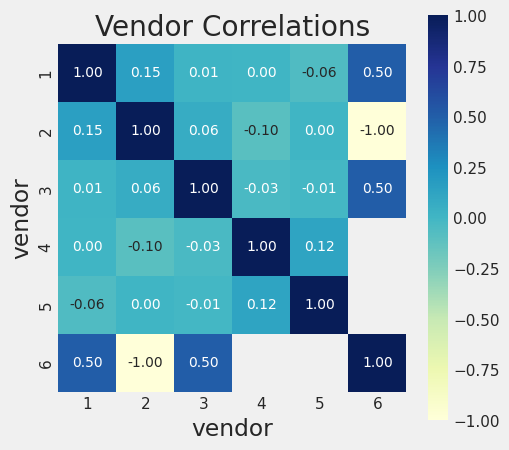

In [198]:
df2_pivot_corr = df2_pivot[[1, 2, 3, 4, 5, 6]].corr(method = 'spearman')
plt.figure(figsize = (5, 5))
sns.heatmap(df2_pivot_corr, annot = True, annot_kws = {'size': 10}, square = True, cmap = 'YlGnBu', fmt = '.2f').set(title = 'Vendor Correlations')
plt.show()

In [199]:
df2_pivot_b = df2_pivot[['product_number', 1, 2]].dropna()

In [200]:
product_list = df2_pivot_b.product_number.unique().tolist()
corr_list = []

for product in product_list:
    corr_list.append(df2_pivot_b.loc[df2_pivot_b.product_number == product].corr()[1][2])
    
# nan
del corr_list[-32]

In [201]:
sum(corr_list) / len(corr_list)

0.045288962345584494

In [202]:
fig = px.line(
    df2.loc[df.product_number == 10857], 
    x = 'date', 
    y = 'sales_inv_ratio',
    color = 'reporterhq_id',
    title = 'Specific Product: Sales over time'
)

fig.show()

In [203]:
# fig = px.line(
#     df.loc[df.segment == 'Core'], 
#     x = 'date', 
#     y = 'sales_units',
#     color = 'reporterhq_id',
#     title = 'Specific Product: Sales over time'
# )

# fig.show()

In [204]:
fig = px.bar(
    df.groupby(['prod_category'])['specs'].mean().reset_index().sort_values(by = 'specs', ascending = False), 
    x = 'prod_category', 
    y = 'specs',
    title = 'Product Cat & Specs'
)

fig.show()

In [205]:
fig = px.bar(
    df.groupby(['prod_category'])['display_size'].mean().reset_index().sort_values(by = 'display_size', ascending = False), 
    x = 'prod_category', 
    y = 'display_size',
    title = 'Product Cat & display_size'
)

fig.show()

In [206]:
fig = px.bar(
    df.groupby(['segment'])['specs'].mean().reset_index().sort_values(by = 'specs', ascending = False), 
    x = 'segment', 
    y = 'specs',
    title = 'Segment & Specs'
)

fig.show()

In [207]:
fig = px.bar(
    df.groupby(['segment'])['display_size'].mean().reset_index().sort_values(by = 'display_size', ascending = False), 
    x = 'segment', 
    y = 'display_size',
    title = 'segment & display_size'
)

fig.show()

In [208]:
fig = px.scatter(
    df, 
    x = 'specs', 
    y = 'display_size',
    color = 'prod_category',
    title = ''
)

fig.show()

In [209]:
fig = px.scatter(
    df, 
    x = 'specs', 
    y = 'sales_units',
    color = 'prod_category',
    title = ''
)

fig.show()

In [210]:
sales_inv = df.groupby(['product_number', 'prod_category', 'segment'])['sales_units', 'inventory_units'].median().reset_index()

In [211]:
fig = px.scatter(
    sales_inv, 
    x = 'sales_units', 
    y = 'inventory_units',
    color = 'prod_category',
    title = 'With Product Categories'
)

fig.update_layout(
    height = 650,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.update_traces(
    marker = dict(
        size = 8,
        line = dict(
            width = 1,
            color = 'Black'
        )
    ),
    selector=dict(mode='markers')
)

fig.show()

In [212]:
sales_inv_array = sales_inv[['sales_units', 'inventory_units']].values

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f128aae6ee0>
Traceback (most recent call last):
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

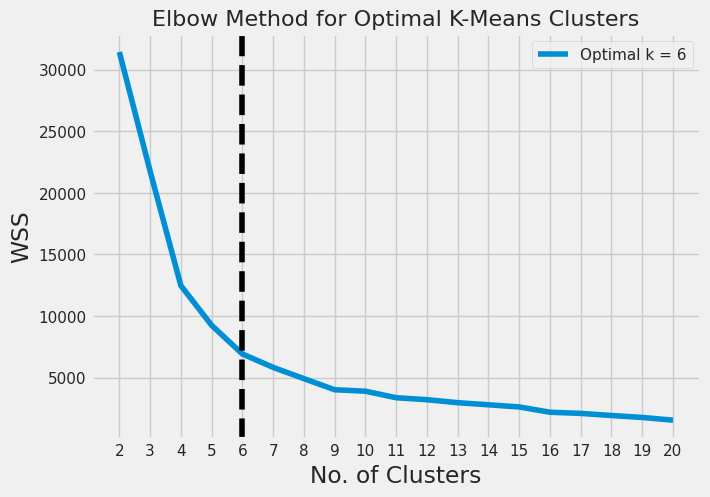

In [213]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

# apply the elbow method to check the 'Within Sum of Squared Distance' and identify the the optimal k clusters to use

wss = []
n = 21

for k in range(2, n):
    kmeans = KMeans(n_clusters = k, random_state = rand_val, n_init = 'auto')
    kmeans.fit(sales_inv_array)
    wss.append(kmeans.inertia_)
    
kl = KneeLocator(range(2, n), wss, curve = 'convex', direction = 'decreasing')
elbow = kl.elbow

plt.figure(figsize = (7, 5))
plt.plot(range(2, n), wss, label = f'Optimal k = {elbow}')
plt.xticks(range(2, n))
plt.axvline(x = elbow, color = 'black', linestyle = '--')
plt.title('Elbow Method for Optimal K-Means Clusters', size = 16)
plt.xlabel("No. of Clusters")
plt.ylabel("WSS")
plt.legend()
plt.show()

In [214]:
# Use the optimal k for applying k-means clustering to the data and have a new column with the assigned clusters

kmeans_model = KMeans(n_clusters = elbow, random_state = rand_val)
sales_inv['cluster'] = kmeans_model.fit_predict(sales_inv_array)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f128bef34c0>
Traceback (most recent call last):
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

In [215]:
sales_inv.head()

,product_number,prod_category,segment,sales_units,inventory_units,cluster
0,6909,Arale,Premium,2.0,30.0,3
1,7896,Goku,Core,7.0,67.0,0
2,8883,Goku,Core,8.0,62.0,0
3,9870,Doraemon,Gaming,12.5,73.0,1
4,10857,Doraemon,Gaming,10.0,51.0,2


In [216]:
# import plotly.io as pio
# pio.templates.default = "plotly_white"

fig = px.scatter(
    sales_inv, 
    x = 'sales_units', 
    y = 'inventory_units',
    color = 'cluster',
    title = 'With new clusters'
)

fig.update_layout(
    height = 650,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.update_traces(
    marker = dict(
        size = 8,
        line = dict(
            width = 1,
            color = 'Black'
        )
    ),
    selector=dict(mode='markers')
)

fig.show()

In [217]:
df3 = df.merge(
    sales_inv,
    how = 'inner',
    left_on = 'product_number',
    right_on = 'product_number'
)[['date', 'product_number', 'reporterhq_id', 'cluster', 'sales_units_x', 'inventory_units_x']]

df3.rename(columns = {'sales_units_x': 'sales_units', 'inventory_units_x': 'inventory_units'}, inplace = True)

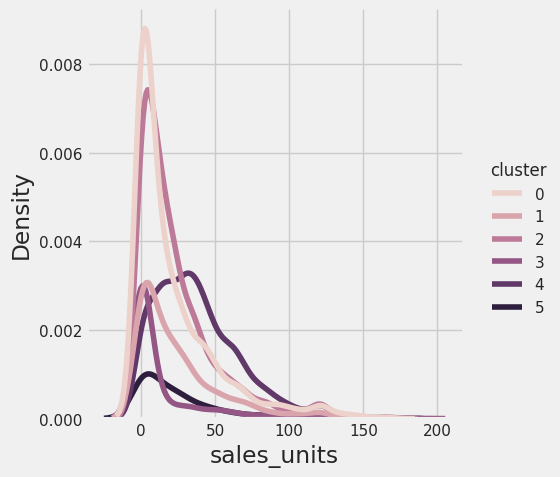

In [218]:
sns.displot(data = df3, x = "sales_units", hue = "cluster", kind = "kde")

In [219]:
fig = px.line(
    df.groupby(['date', 'prod_category'])['sales_units'].median().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'prod_category',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [220]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['sales_units'].median().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [221]:
fig = px.line(
    df.groupby(['date', 'prod_category'])['inventory_units'].median().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'prod_category',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [222]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['inventory_units'].median().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [223]:
fig = px.line(
    df.groupby(['date', 'prod_category'])['sales_units'].sum().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'prod_category',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [224]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['sales_units'].sum().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [225]:
fig = px.line(
    df.groupby(['date', 'prod_category'])['inventory_units'].sum().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'prod_category',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [226]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['inventory_units'].sum().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [227]:
fig = px.line(
    df.groupby(['date', 'segment'])['sales_units'].sum().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'segment',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [228]:
sales_inv

,product_number,prod_category,segment,sales_units,inventory_units,cluster
0,6909,Arale,Premium,2.0,30.0,3
1,7896,Goku,Core,7.0,67.0,0
2,8883,Goku,Core,8.0,62.0,0
3,9870,Doraemon,Gaming,12.5,73.0,1
4,10857,Doraemon,Gaming,10.0,51.0,2
...,...,...,...,...,...,...
95,238854,Goku,Core,8.0,62.0,0
96,239841,Goku,Core,7.0,57.5,0
97,240828,Conan,Premium,9.5,125.0,5
98,242802,Conan,Premium,9.5,54.0,0


In [229]:
fig = px.scatter(
    sales_inv, 
    x = 'sales_units', 
    y = 'inventory_units',
    color = 'segment',
    title = 'With Segments'
)

fig.update_layout(
    height = 650,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.update_traces(
    marker = dict(
        size = 8,
        line = dict(
            width = 1,
            color = 'Black'
        )
    ),
    selector=dict(mode='markers')
)

fig.show()

<AxesSubplot: xlabel='sales_units', ylabel='Density'>

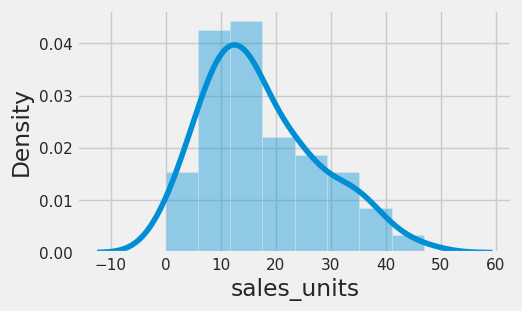

In [230]:
sns.distplot(sales_inv.sales_units)

<AxesSubplot: xlabel='inventory_units', ylabel='Density'>

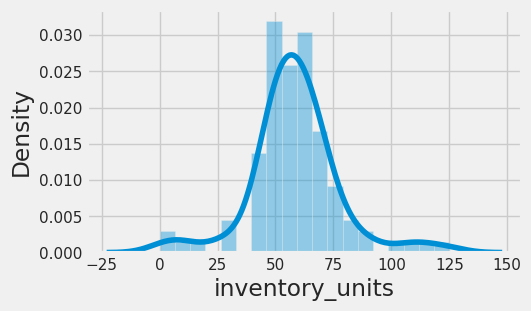

In [231]:
sns.distplot(sales_inv.inventory_units)

In [232]:
# def SelBest(arr:list, X:int)->list:
#     '''
#     returns the set of X configurations with shorter distance
#     '''
#     dx=np.argsort(arr)[:X]
#     return arr[dx]

In [233]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics

# n_clusters=np.arange(2, 11)
# sils=[]
# sils_err=[]
# iterations=20
# for n in n_clusters:
#     tmp_sil=[]
#     for _ in range(iterations):
#         gmm=GaussianMixture(n, n_init=2).fit(sales_inv_array) 
#         labels=gmm.predict(sales_inv_array)
#         sil=metrics.silhouette_score(sales_inv_array, labels, metric='euclidean')
#         tmp_sil.append(sil)
#     val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
#     err=np.std(tmp_sil)
#     sils.append(val)
#     sils_err.append(err)

In [234]:
# plt.errorbar(n_clusters, sils, yerr=sils_err)
# plt.title("Silhouette Scores", fontsize=20)
# plt.xticks(n_clusters)
# plt.xlabel("N. of clusters")
# plt.ylabel("Score")

In [235]:
gmm = GaussianMixture(n_components = 4).fit(sales_inv_array)
sales_inv['gmm_cluster'] = gmm.predict(sales_inv_array)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f129847a3a0>
Traceback (most recent call last):
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/koumudi/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

In [236]:
fig = px.scatter(
    sales_inv, 
    x = 'sales_units', 
    y = 'inventory_units',
    color = 'gmm_cluster',
    title = 'With gmm clusters'
)

fig.update_layout(
    height = 650,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.update_traces(
    marker = dict(
        size = 8,
        line = dict(
            width = 1,
            color = 'Black'
        )
    ),
    selector=dict(mode='markers')
)

fig.show()

In [237]:
df4 = df.merge(
    sales_inv,
    how = 'inner',
    left_on = 'product_number',
    right_on = 'product_number'
)[['date', 'product_number', 'reporterhq_id', 'gmm_cluster', 'sales_units_x', 'inventory_units_x']]

df4.rename(columns = {'sales_units_x': 'sales_units', 'inventory_units_x': 'inventory_units'}, inplace = True)

In [238]:
fig = px.line(
    df4.groupby(['date', 'gmm_cluster'])['inventory_units'].sum().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'gmm_cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [239]:
fig = px.line(
    df4.groupby(['date', 'gmm_cluster'])['sales_units'].sum().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'gmm_cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [240]:
fig = px.line(
    df4.groupby(['date', 'gmm_cluster'])['inventory_units'].median().reset_index(), 
    x = 'date', 
    y = 'inventory_units',
    color = 'gmm_cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [241]:
fig = px.line(
    df4.groupby(['date', 'gmm_cluster'])['sales_units'].median().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'gmm_cluster',
    title = ''
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [242]:
sales_inv

,product_number,prod_category,segment,sales_units,inventory_units,cluster,gmm_cluster
0,6909,Arale,Premium,2.0,30.0,3,0
1,7896,Goku,Core,7.0,67.0,0,2
2,8883,Goku,Core,8.0,62.0,0,2
3,9870,Doraemon,Gaming,12.5,73.0,1,2
4,10857,Doraemon,Gaming,10.0,51.0,2,2
...,...,...,...,...,...,...,...
95,238854,Goku,Core,8.0,62.0,0,2
96,239841,Goku,Core,7.0,57.5,0,2
97,240828,Conan,Premium,9.5,125.0,5,3
98,242802,Conan,Premium,9.5,54.0,0,2


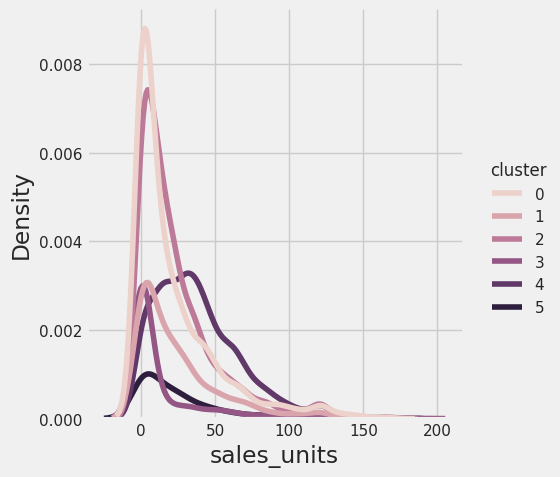

In [243]:
sns.displot(data = df3, x = "sales_units", hue = "cluster", kind = "kde")

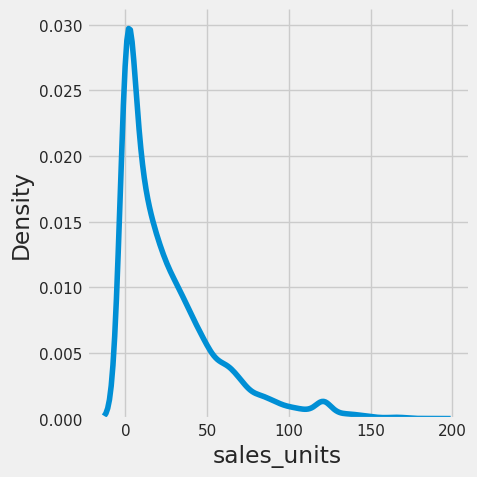

In [244]:
sns.displot(data = df3, x = "sales_units", kind = "kde")

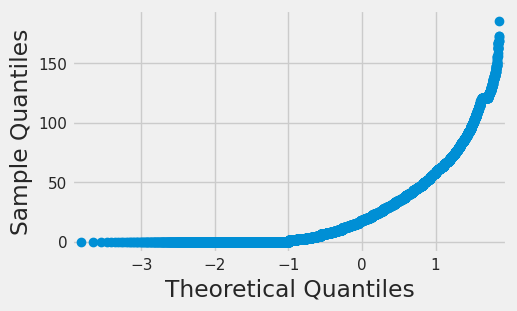

In [245]:
qqplot(df3['sales_units'], line = 's')
plt.show()

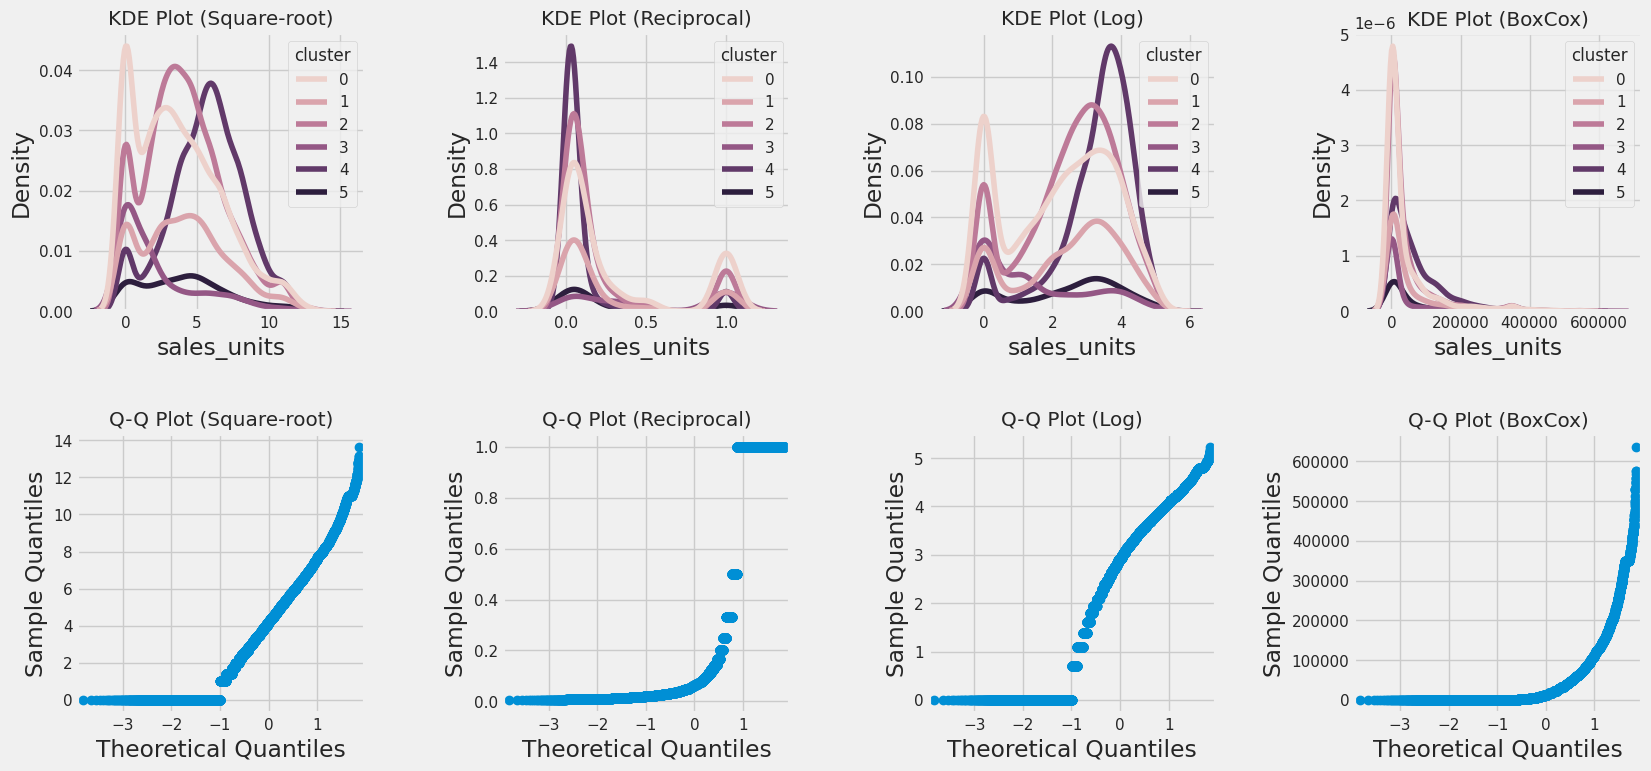

In [246]:
fig, ax = plt.subplots(2, 4, figsize = (18, 9), squeeze = True)
fig.tight_layout(pad = 5)
plt.rcParams['font.size'] = '10'

# square-root transformation
df_transform = df3.copy()
df_transform.sales_units = np.sqrt(df_transform.sales_units)
sns.kdeplot(data = df_transform, x = "sales_units", hue = "cluster", ax = ax[0][0])
ax[0][0].set(title = 'KDE Plot (Square-root)')
qqplot(df_transform['sales_units'], line = 's', ax = ax[1][0])
ax[1][0].set(title = 'Q-Q Plot (Square-root)')

# # reciprocal transformation
df_transform = df3.copy()
df_transform.sales_units = (1 / (np.array(df_transform.sales_units) + 1))
sns.kdeplot(data = df_transform, x = "sales_units", hue = "cluster", ax = ax[0][1])
ax[0][1].set(title = 'KDE Plot (Reciprocal)')
qqplot(df_transform['sales_units'], line = 's', ax = ax[1][1])
ax[1][1].set(title = 'Q-Q Plot (Reciprocal)')

# # log transformation
df_transform = df3.copy()
df_transform.sales_units = np.log(np.array(df_transform.sales_units) + 1)
sns.kdeplot(data = df_transform, x = "sales_units", hue = "cluster", ax = ax[0][2])
ax[0][2].set(title = 'KDE Plot (Log)')
qqplot(df_transform['sales_units'], line = 's', ax = ax[1][2])
ax[1][2].set(title = 'Q-Q Plot (Log)')

# # boxcox transformation
df_transform = df3.copy()
df_transform.sales_units = np.log(np.array(df_transform.sales_units) + 1)
df_transform['sales_units'], bc_lambda = boxcox((df_transform['sales_units'] + 1).values)
sns.kdeplot(data = df_transform, x = "sales_units", hue = "cluster", ax = ax[0][3])
ax[0][3].set(title = 'KDE Plot (BoxCox)')
qqplot(df_transform['sales_units'], line = 's', ax = ax[1][3])
ax[1][3].set(title = 'Q-Q Plot (BoxCox)', )


plt.show()

In [247]:
df

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,sales_units,inventory_units,week,year
972,202101-12831,2021-01-09,202101,12831,12,Doraemon,180829,15.6,Gaming,8.0,50.0,01,2021
14183,202101-235893,2021-01-09,202101,235893,24,Clover,50284,17.3,Core,21.0,44.0,01,2021
13657,202101-233919,2021-01-09,202101,233919,24,Clover,106370,15.6,Core,0.0,0.0,01,2021
13656,202101-233919,2021-01-09,202101,233919,3,Clover,106370,15.6,Core,2.0,0.0,01,2021
781,202101-11844,2021-01-09,202101,11844,12,Doraemon,109271,15.6,Gaming,32.0,25.0,01,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10360,202318-182595,2023-05-06,202318,182595,3,Clover,84129,17.3,Core,NaN,58.0,18,2023
11955,202318-204309,2023-05-06,202318,204309,15,Doraemon,38680,16.1,Gaming,0.0,84.0,18,2023
11956,202318-204309,2023-05-06,202318,204309,21,Doraemon,38680,16.1,Gaming,40.0,72.0,18,2023
8708,202318-148050,2023-05-06,202318,148050,12,Clover,79294,17.3,Core,9.0,66.0,18,2023


In [248]:
df_transform = df.copy()
df_transform.sales_units = np.log(np.array(df_transform.sales_units) + 1)
df_transform.inventory_units = np.log(np.array(df_transform.inventory_units) + 1)
df_transform.rename(columns = {'sales_units': 'log_sales', 'inventory_units': 'log_inventory'}, inplace = True)

In [249]:
fig = px.line(
    df_transform.loc[df_transform.product_number == 10857], 
    x = 'date', 
    y = 'log_sales',
    color = 'reporterhq_id',
    title = 'Specific Product: Sales over time'
)

fig.show()

In [250]:
df_transform_final = df_transform.merge(
    sales_inv,
    how = 'inner',
    left_on = 'product_number',
    right_on = 'product_number'
)[['id', 'date', 'year_week', 'product_number', 'reporterhq_id', 'prod_category_x', 'specs', 'display_size', 'segment_x', 'log_sales', 'log_inventory', 'week', 'year', 'cluster', 'gmm_cluster']]

df_transform_final.rename(
    columns = {
        'prod_category_x': 'prod_category',
        'segment_x': 'segment',
        'cluster': 'km_cluster'
    },
    inplace = True
)

In [251]:
df_transform_final.head()

,id,date,year_week,product_number,reporterhq_id,prod_category,specs,display_size,segment,log_sales,log_inventory,week,year,km_cluster,gmm_cluster
0,202101-12831,2021-01-09,202101,12831,12,Doraemon,180829,15.6,Gaming,2.197225,3.931826,01,2021,0,2
1,202102-12831,2021-01-16,202102,12831,12,Doraemon,180829,15.6,Gaming,4.143135,4.543295,02,2021,0,2
2,202103-12831,2021-01-23,202103,12831,12,Doraemon,180829,15.6,Gaming,4.753590,4.330733,03,2021,0,2
3,202108-12831,2021-02-27,202108,12831,12,Doraemon,180829,15.6,Gaming,2.484907,4.644391,08,2021,0,2
4,202109-12831,2021-03-06,202109,12831,12,Doraemon,180829,15.6,Gaming,4.290459,4.094345,09,2021,0,2


In [252]:
vector_list = df_transform_final[['year', 'week', 'specs', 'display_size', 'log_sales', 'log_inventory', 'gmm_cluster']]

In [253]:
vector_list = vector_list.join(pd.get_dummies(vector_list.gmm_cluster, prefix = 'gmm_cluster'))
vector_list.drop(columns = ['gmm_cluster'], inplace = True)

In [254]:
vector_list.head()

,year,week,specs,display_size,log_sales,log_inventory,gmm_cluster_0,gmm_cluster_1,gmm_cluster_2,gmm_cluster_3
0,2021,01,180829,15.6,2.197225,3.931826,0,0,1,0
1,2021,02,180829,15.6,4.143135,4.543295,0,0,1,0
2,2021,03,180829,15.6,4.753590,4.330733,0,0,1,0
3,2021,08,180829,15.6,2.484907,4.644391,0,0,1,0
4,2021,09,180829,15.6,4.290459,4.094345,0,0,1,0


In [255]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
vector_list = pd.DataFrame(scaler.fit_transform(vector_list), columns = vector_list.columns)
vector_list.head()

,year,week,specs,display_size,log_sales,log_inventory,gmm_cluster_0,gmm_cluster_1,gmm_cluster_2,gmm_cluster_3
0,0.0,0.000000,0.762295,0.730159,0.420030,0.656238,0.0,0.0,1.0,0.0
1,0.0,0.019608,0.762295,0.730159,0.792018,0.758295,0.0,0.0,1.0,0.0
2,0.0,0.039216,0.762295,0.730159,0.908716,0.722817,0.0,0.0,1.0,0.0
3,0.0,0.137255,0.762295,0.730159,0.475025,0.775168,0.0,0.0,1.0,0.0
4,0.0,0.156863,0.762295,0.730159,0.820182,0.683363,0.0,0.0,1.0,0.0


In [256]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 5)
knn_result = pd.DataFrame(imputer.fit_transform(vector_list), columns = vector_list.columns)

In [257]:
knn_result

,year,week,specs,display_size,log_sales,log_inventory,gmm_cluster_0,gmm_cluster_1,gmm_cluster_2,gmm_cluster_3
0,0.0,0.000000,0.762295,0.730159,0.420030,0.656238,0.0,0.0,1.0,0.0
1,0.0,0.019608,0.762295,0.730159,0.792018,0.758295,0.0,0.0,1.0,0.0
2,0.0,0.039216,0.762295,0.730159,0.908716,0.722817,0.0,0.0,1.0,0.0
3,0.0,0.137255,0.762295,0.730159,0.475025,0.775168,0.0,0.0,1.0,0.0
4,0.0,0.156863,0.762295,0.730159,0.820182,0.683363,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
15171,1.0,0.313725,0.872951,0.730159,0.504493,0.659479,0.0,0.0,0.0,1.0
15172,1.0,0.333333,0.872951,0.730159,0.622831,0.623832,0.0,0.0,0.0,1.0
15173,1.0,0.333333,0.872951,0.730159,0.679655,0.768622,0.0,0.0,0.0,1.0
15174,1.0,0.333333,0.872951,0.730159,0.000000,0.578446,0.0,0.0,0.0,1.0


In [258]:
knn_result = pd.DataFrame(scaler.inverse_transform(knn_result), columns = knn_result.columns)
knn_result.head()

,year,week,specs,display_size,log_sales,log_inventory,gmm_cluster_0,gmm_cluster_1,gmm_cluster_2,gmm_cluster_3
0,2021.0,1.0,180829.0,15.6,2.197225,3.931826,0.0,0.0,1.0,0.0
1,2021.0,2.0,180829.0,15.6,4.143135,4.543295,0.0,0.0,1.0,0.0
2,2021.0,3.0,180829.0,15.6,4.753590,4.330733,0.0,0.0,1.0,0.0
3,2021.0,8.0,180829.0,15.6,2.484907,4.644391,0.0,0.0,1.0,0.0
4,2021.0,9.0,180829.0,15.6,4.290459,4.094345,0.0,0.0,1.0,0.0


In [259]:
df_transform_final = df_transform_final[['id', 'date', 'year_week', 'product_number', 'reporterhq_id', 'km_cluster', 'gmm_cluster']].merge(
    knn_result,
    how = 'inner',
    left_index = True,
    right_index = True
).drop(columns = ['gmm_cluster_0', 'gmm_cluster_1', 'gmm_cluster_2', 'gmm_cluster_3'])

In [260]:
df_transform_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15176 entries, 0 to 15175
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15176 non-null  object        
 1   date            15176 non-null  datetime64[ns]
 2   year_week       15176 non-null  int64         
 3   product_number  15176 non-null  int64         
 4   reporterhq_id   15176 non-null  int64         
 5   km_cluster      15176 non-null  int32         
 6   gmm_cluster     15176 non-null  int64         
 7   year            15176 non-null  float64       
 8   week            15176 non-null  float64       
 9   specs           15176 non-null  float64       
 10  display_size    15176 non-null  float64       
 11  log_sales       15176 non-null  float64       
 12  log_inventory   15176 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(1), int64(4), object(1)
memory usage: 2.1+ MB


In [261]:
fig = px.line(
    df_transform.loc[df_transform.product_number == 8883], 
    x = 'date', 
    y = 'log_sales',
    color = 'reporterhq_id',
    title = 'Specific Product: Sales over time (with missing data)'
)

fig.show()

In [262]:
fig = px.line(
    df_transform_final.loc[df_transform_final.product_number == 8883], 
    x = 'date', 
    y = 'log_sales',
    color = 'reporterhq_id',
    title = 'Specific Product: Sales over time (with imputation)'
)

fig.show()

In [263]:
fig = px.line(
    df_transform_final.loc[df_transform_final.product_number == 8883], 
    x = 'date', 
    y = 'log_inventory',
    color = 'reporterhq_id',
    title = 'Specific Product: Inventory over time'
)

fig.show()

In [264]:
df_transform_final.log_sales = np.exp(df_transform_final.log_sales) - 1
df_transform_final.log_inventory = np.exp(df_transform_final.log_inventory) - 1

In [265]:
df_transform_final = df_transform_final.groupby([
    'id', 'date', 'year_week', 
    'product_number', 'km_cluster', 'gmm_cluster', 
    'year', 'week', 'specs', 'display_size']
)['log_sales', 'log_inventory'].sum().reset_index()

In [266]:
df_transform_final.log_sales = np.log(np.array(df_transform_final.log_sales) + 1)
df_transform_final.log_inventory = np.log(np.array(df_transform_final.log_inventory) + 1)

In [267]:
df_transform_final.describe()

,year_week,product_number,km_cluster,gmm_cluster,year,week,specs,display_size,log_sales,log_inventory
count,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000
mean,202233.017257,124325.837515,1.936148,1.588477,2022.082305,24.786805,110235.175893,15.140422,3.337675,4.555964
std,55.530165,79990.084575,1.596027,0.771942,0.622103,15.526354,64307.578206,1.428757,1.387863,1.148395
min,202101.000000,6909.000000,0.000000,0.000000,2021.000000,1.000000,967.000000,11.000000,0.000000,0.000000
25%,202211.000000,48363.000000,0.000000,1.000000,2022.000000,11.000000,58020.000000,14.000000,2.701205,4.143135
50%,202232.000000,114492.000000,2.000000,2.000000,2022.000000,23.000000,108304.000000,15.600000,3.713572,4.780527
75%,202252.000000,197400.000000,4.000000,2.000000,2022.000000,39.000000,156654.000000,15.600000,4.330733,5.267858
max,202318.000000,247737.000000,5.000000,3.000000,2023.000000,52.000000,236915.000000,17.300000,5.817111,6.791221


In [268]:
fig = px.line(
    df3.groupby(['date', 'cluster'])['sales_units'].median().reset_index(), 
    x = 'date', 
    y = 'sales_units',
    color = 'cluster',
    title = 'Sales without transformation & imputation'
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

In [269]:
fig = px.line(
    df_transform_final.groupby(['date', 'gmm_cluster'])['log_sales'].median().reset_index(), 
    x = 'date', 
    y = 'log_sales',
    color = 'gmm_cluster',
    title = 'Sales with log transformation, knn-imputation & vendor aggregation'
)

fig.update_layout(
    height = 500,
    coloraxis = dict( colorscale = 'Spectral')
)

fig.show()

---

## Timeseries Forecasting

In [270]:
df_transform_final.head()

,id,date,year_week,product_number,km_cluster,gmm_cluster,year,week,specs,display_size,log_sales,log_inventory
0,202101-11844,2021-01-09,202101,11844,0,2,2021.0,1.0,109271.0,15.6,3.496508,3.258097
1,202101-12831,2021-01-09,202101,12831,0,2,2021.0,1.0,180829.0,15.6,2.197225,3.931826
2,202101-233919,2021-01-09,202101,233919,3,0,2021.0,1.0,106370.0,15.6,1.098612,0.000000
3,202101-235893,2021-01-09,202101,235893,3,0,2021.0,1.0,50284.0,17.3,3.091042,3.806662
4,202101-247737,2021-01-09,202101,247737,2,0,2021.0,1.0,10637.0,13.3,3.912023,2.197225


In [271]:
clusters = df_transform_final.groupby(['date', 'gmm_cluster'])['log_sales', 'log_inventory'].mean().reset_index()
clusters.head()

,date,gmm_cluster,log_sales,log_inventory
0,2021-01-09,0,2.700559,2.001296
1,2021-01-09,2,3.318804,3.853123
2,2021-01-16,0,1.997155,2.140541
3,2021-01-16,2,2.941755,4.166123
4,2021-01-23,0,2.118703,2.376433


In [272]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=clusters.loc[clusters.gmm_cluster == 0].date, y=clusters.loc[clusters.gmm_cluster == 0].log_sales,
                    mode='lines',
                    name='Log Sales'))
fig.add_trace(go.Scatter(x=clusters.loc[clusters.gmm_cluster == 0].date, y=clusters.loc[clusters.gmm_cluster == 0].log_inventory,
                    mode='lines',
                    name='Log Inventory'))

fig.update_layout(
    height = 500,
    title = 'Cluster 0',
    coloraxis = dict( colorscale = 'Spectral')
)


fig.show()

In [273]:
weights = df_transform_final.merge(
    clusters,
    how = 'inner',
    left_on = ['date', 'gmm_cluster'],
    right_on = ['date', 'gmm_cluster']
)

In [274]:
weights.log_sales_x = np.exp(weights.log_sales_x) - 1
weights.log_inventory_x = np.exp(weights.log_inventory_x) - 1

weights.log_sales_y = np.exp(weights.log_sales_y) - 1
weights.log_inventory_y = np.exp(weights.log_inventory_y) - 1

In [275]:
weights['log_sales_weight'] = weights['log_sales_y'] - weights['log_sales_x']
weights['log_inventory_weight'] = weights['log_inventory_y'] - weights['log_inventory_x']

In [276]:
weights_final = weights.groupby(['product_number', 'gmm_cluster'])['log_sales_weight', 'log_inventory_weight'].median().reset_index()

In [277]:
weights_final

,product_number,gmm_cluster,log_sales_weight,log_inventory_weight
0,6909,0,1.913792,-15.939812
1,7896,2,6.208332,-8.076566
2,8883,2,0.493007,-28.218314
3,9870,2,-5.174893,2.301179
4,10857,2,1.761034,17.494405
...,...,...,...,...
95,238854,2,2.793507,11.127326
96,239841,2,1.498607,10.367060
97,240828,3,10.894916,19.483913
98,242802,2,3.341027,21.611808


## Serious time

In [278]:
def run_adf_test(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [279]:
ts = clusters.loc[clusters.gmm_cluster == 0].drop(columns = ['gmm_cluster', 'log_sales']).set_index('date')
ts_train = ts[:-13]
ts_test = ts[-13:]

In [280]:
ts_train.head()

,log_inventory
date,
2021-01-09,2.001296
2021-01-16,2.140541
2021-01-23,2.376433
2021-01-30,2.217621
2021-02-06,2.196767


In [281]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = ts_train.index, y = ts_train.log_inventory,
                    mode = 'lines',
                    name = 'Log Inventory'))

fig.update_layout(
    height = 500,
    title = 'Cluster 0: Log Inventory',
    coloraxis = dict( colorscale = 'Spectral')
)


fig.show()

In [282]:
run_adf_test(ts)

ADF Statistic: -2.729619
p-value: 0.069052


In [283]:
diff_ts = ts_train.diff().dropna()

In [284]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = diff_ts.index, y = diff_ts.log_inventory,
                    mode = 'lines',
                    name = 'Log Inventory'))

fig.update_layout(
    height = 500,
    title = 'Cluster 0: Log Inventory (First differencing)',
    coloraxis = dict( colorscale = 'Spectral')
)


fig.show()

In [285]:
run_adf_test(diff_ts)

ADF Statistic: -10.781320
p-value: 0.000000


In [286]:
sdiff_ts = diff_ts.diff().dropna()

In [287]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = sdiff_ts.index, y = sdiff_ts.log_inventory,
                    mode = 'lines',
                    name = 'Log Inventory'))

fig.update_layout(
    height = 500,
    title = 'Cluster 0: Log Inventory (Second differencing)',
    coloraxis = dict( colorscale = 'Spectral')
)


fig.show()

In [288]:
run_adf_test(sdiff_ts)

ADF Statistic: -6.847033
p-value: 0.000000


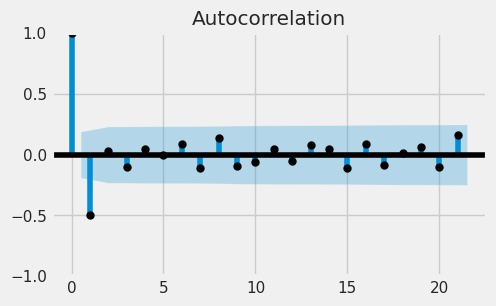

In [289]:
plot_acf(sdiff_ts, color = 'black')
plt.show()

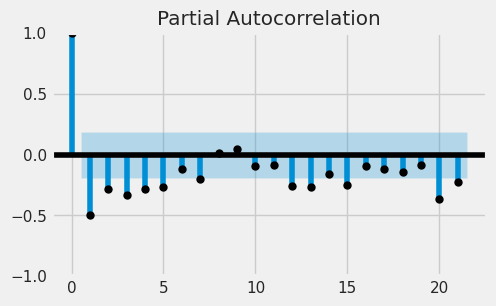

In [290]:
plot_pacf(sdiff_ts, color = 'black')
plt.show()

In [291]:
model = auto_arima(
    sdiff_ts,
    # d = 1,
    # D = 1,
    # m = 1,
    start_p = 0,
    max_p = 3,
    start_q = 0,
    max_q = 3,
    start_P = 0,
    max_P = 3,
    start_Q = 0,
    max_Q = 3,
    max_order = 6,
    trace = True,
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=151.488, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=122.781, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=149.499, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=116.520, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=106.936, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=104.952, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=114.534, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.371 seconds


In [292]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  107
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 -48.476
Date:                Sun, 14 May 2023   AIC                            104.952
Time:                        08:49:29   BIC                            115.643
Sample:                    01-23-2021   HQIC                           109.286
                         - 02-04-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7271      0.097     -7.458      0.000      -0.918      -0.536
ar.L2         -0.4750      0.129     -3.672      0.000      -0.728      -0.221
ar.L3         -0.3248      0.093     -3.481      0.001      -0.508      -0.142
sigma2         0.1438      0.013     11.303      0.000       0.119       0.169
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):               130.18
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             1.19
Prob(H) (two-sided):                  0.22   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

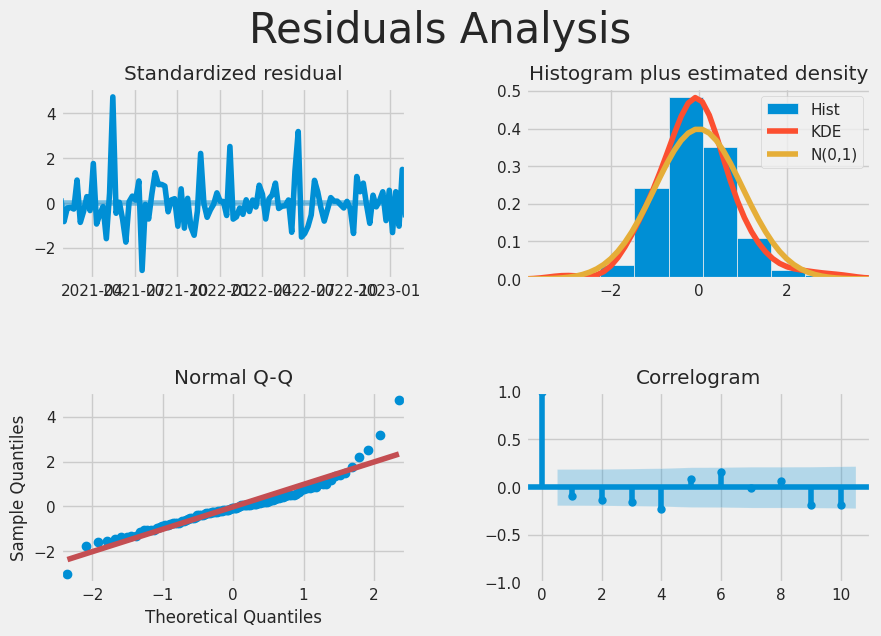

In [293]:
plt.rcParams.update({'figure.figsize': (10, 7)})
model.plot_diagnostics()
plt.tight_layout(pad = 5)
plt.suptitle('Residuals Analysis', fontsize = 30)
plt.show()

In [294]:
in_sample_preds = model.predict_in_sample(return_conf_int = False, dynamic = False)

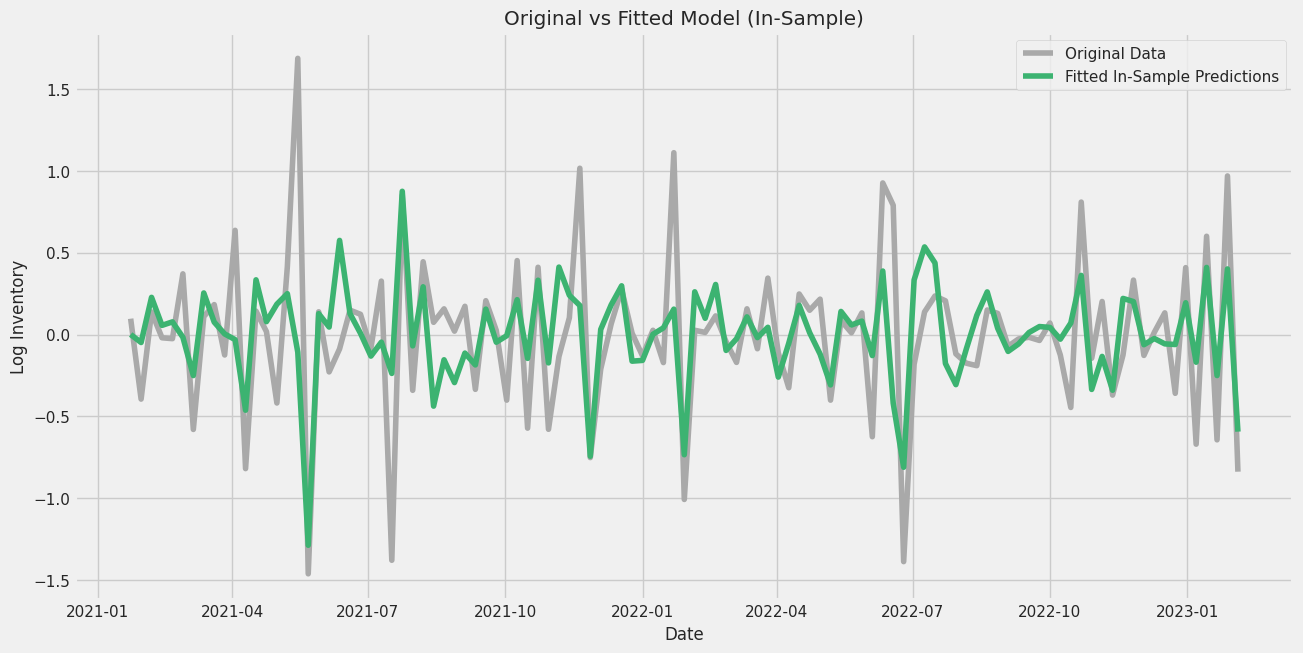

In [295]:
plt.rcParams.update({'figure.figsize': (14, 7)})
plt.plot(sdiff_ts, color = 'darkgrey', label = 'Original Data')
plt.plot(in_sample_preds, color = 'mediumseagreen', label = 'Fitted In-Sample Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title('Original vs Fitted Model (In-Sample)')
plt.show()

In [296]:
period = 13
fc, conf_int = model.predict(n_periods = period, return_conf_int = True, alpha = 0.05)

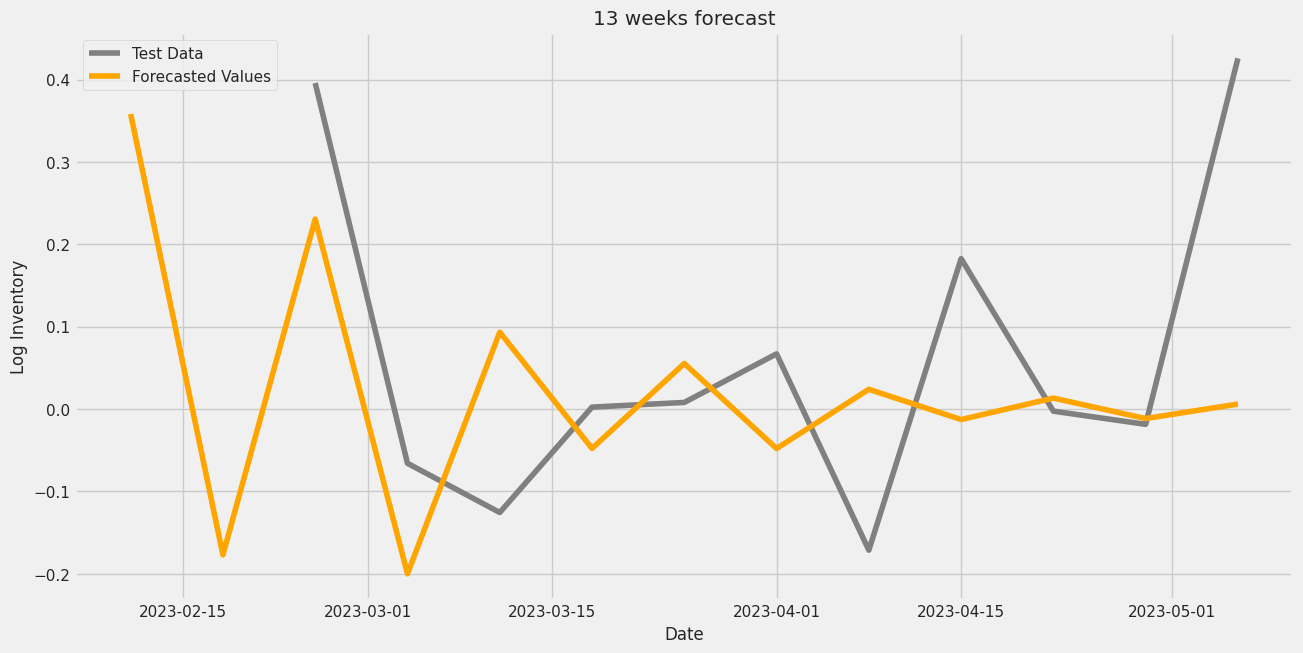

In [297]:
plt.plot(ts_test.diff().dropna().diff().dropna(), color = 'grey', label = 'Test Data')
plt.plot(fc, color = 'orange', label = 'Forecasted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title(f'13 weeks forecast')
plt.show()

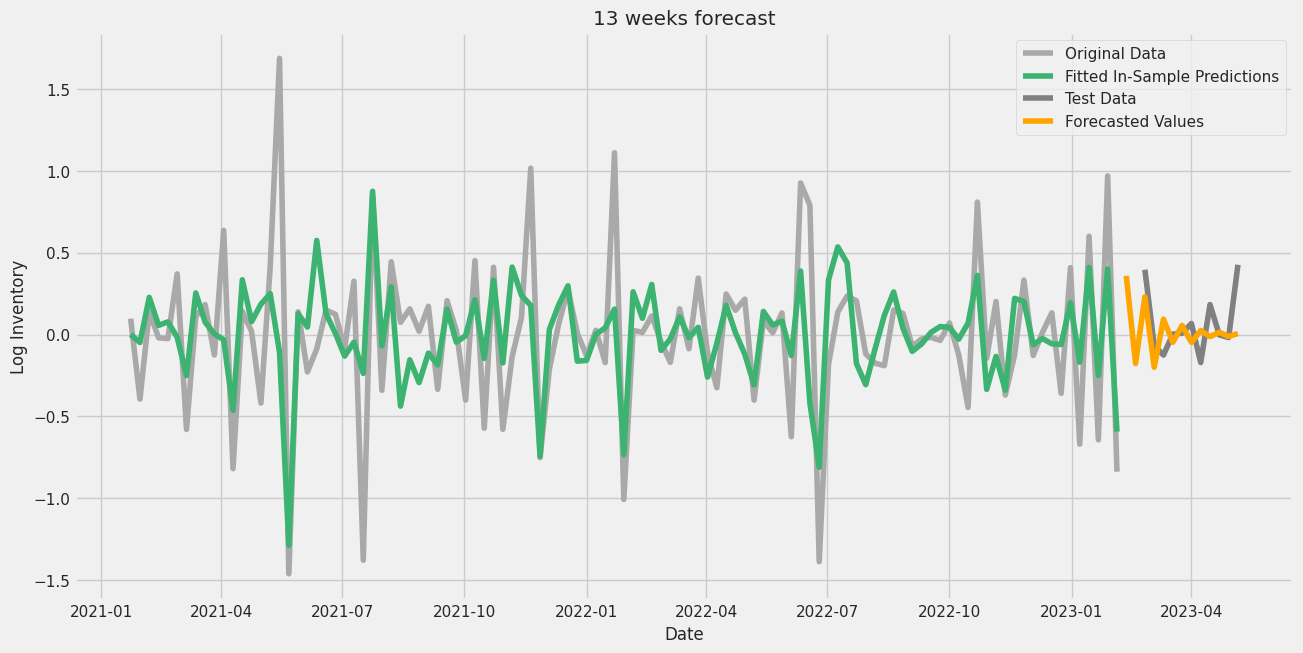

In [298]:
plt.plot(sdiff_ts, color = 'darkgrey', label = 'Original Data')
plt.plot(in_sample_preds, color = 'mediumseagreen', label = 'Fitted In-Sample Predictions')
plt.plot(ts_test.diff().dropna().diff().dropna(), color = 'grey', label = 'Test Data')
plt.plot(fc, color = 'orange', label = 'Forecasted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title(f'13 weeks forecast')
plt.show()

In [299]:
fc = fc.to_frame().rename(columns = {0: 'forecast'})
fc

,forecast
2023-02-11,0.358266
2023-02-18,-0.176983
2023-02-25,0.230662
2023-03-04,-0.200004
2023-03-11,0.093342
2023-03-18,-0.047782
2023-03-25,0.055361
2023-04-01,-0.047872
2023-04-08,0.024030
2023-04-15,-0.012714


In [300]:
fc['forecast_cumsum'] = fc['forecast'].cumsum()
fc['first'] = fc['forecast_cumsum']+ diff_ts.reset_index()[-1:]['log_inventory'].item()
fc['first_cumsum'] = fc['first'].cumsum()
fc['second'] = fc['first_cumsum']+ ts_train.reset_index()[-1:]['log_inventory'].item()
fc

,forecast,forecast_cumsum,first,first_cumsum,second
2023-02-11,0.358266,0.358266,-0.030264,-0.030264,2.861876
2023-02-18,-0.176983,0.181283,-0.207247,-0.237511,2.654629
2023-02-25,0.230662,0.411945,0.023415,-0.214097,2.678044
2023-03-04,-0.200004,0.211941,-0.176589,-0.390686,2.501454
2023-03-11,0.093342,0.305283,-0.083248,-0.473934,2.418207
2023-03-18,-0.047782,0.257501,-0.131030,-0.604963,2.287177
2023-03-25,0.055361,0.312862,-0.075668,-0.680631,2.211509
2023-04-01,-0.047872,0.264990,-0.123540,-0.804172,2.087969
2023-04-08,0.024030,0.289020,-0.099510,-0.903682,1.988459
2023-04-15,-0.012714,0.276306,-0.112224,-1.015906,1.876235


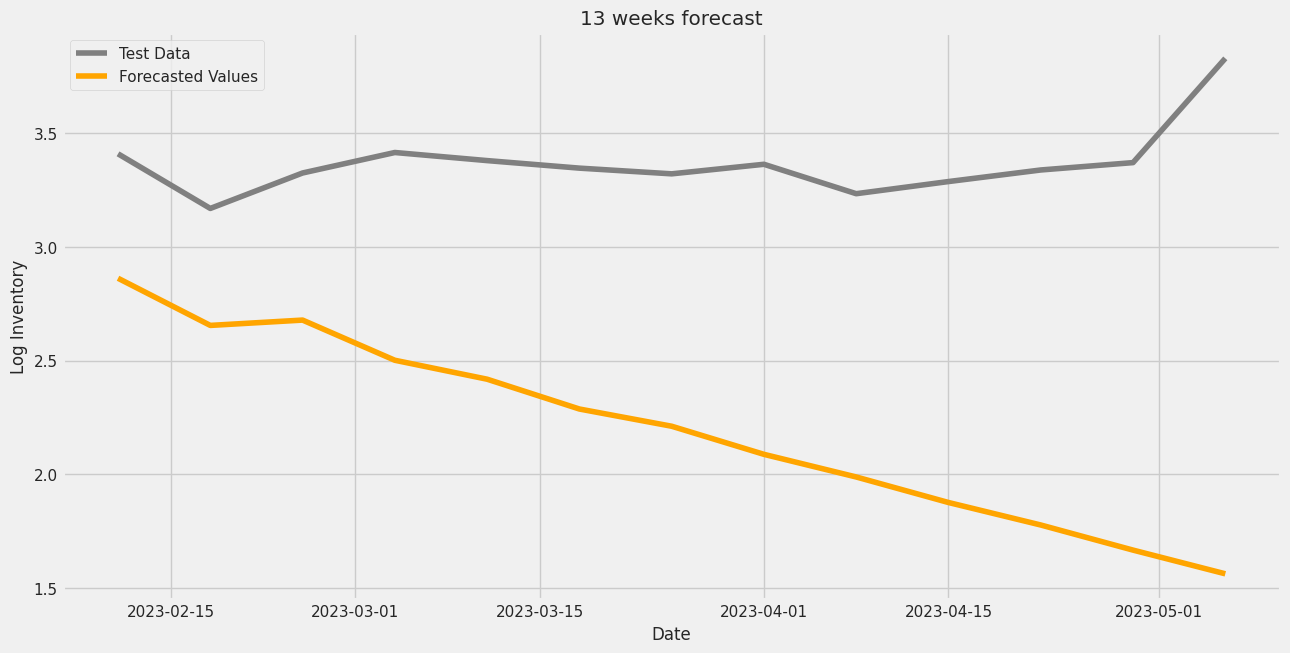

In [301]:
plt.plot(ts_test, color = 'grey', label = 'Test Data')
plt.plot(fc.second, color = 'orange', label = 'Forecasted Values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Inventory')
plt.title(f'13 weeks forecast')
plt.show()

In [302]:
# evaluation = fc.merge(
#     ts_test,
#     left_index = True,
#     right_index = True
# )

In [303]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(np.exp(ts_test) - 1, np.exp(fc.second) - 1, squared = False)

In [304]:
rmse

20.94733686358794

In [305]:
def ts_forecasting(cluster, data, feature):
    
    ts = data.loc[data.gmm_cluster == cluster][['date', feature]].set_index('date')
    # ts_train = ts[:-13]
    # ts_test = ts[-13:]
    ts_train = ts
    
    diff_ts = ts_train.diff().dropna()
    sdiff_ts = diff_ts.diff().dropna()
    
    run_adf_test(sdiff_ts)
    
    model = auto_arima(
        sdiff_ts,
        # d = 1,
        # D = 1,
        # m = 1,
        start_p = 0,
        max_p = 3,
        start_q = 0,
        max_q = 3,
        start_P = 0,
        max_P = 3,
        start_Q = 0,
        max_Q = 3,
        max_order = 6,
        trace = True,
    )
    
    print(model.summary())
    
    in_sample_preds = model.predict_in_sample(return_conf_int = False, dynamic = False)

    period = 13
    fc, conf_int = model.predict(n_periods = period, return_conf_int = True, alpha = 0.05)

    fc = fc.to_frame().rename(columns = {0: 'forecast'})

    fc['forecast_cumsum'] = fc['forecast'].cumsum()
    fc['first'] = fc['forecast_cumsum']+ diff_ts.reset_index()[-1:][feature].item()
    fc['first_cumsum'] = fc['first'].cumsum()
    fc['second'] = fc['first_cumsum']+ ts_train.reset_index()[-1:][feature].item()

    rmse = mean_squared_error(np.exp(ts_test) - 1, np.exp(fc.second) - 1, squared = False)
    
    fc = np.exp(fc[['second']]) - 1
    fc.rename(columns = {'second': feature}, inplace = True)
    fc.reset_index(inplace = True)

    return fc

In [306]:
c0 = ts_forecasting(0, clusters, 'log_inventory')
c1 = ts_forecasting(1, clusters, 'log_inventory')
c2 = ts_forecasting(2, clusters, 'log_inventory')
c3 = ts_forecasting(3, clusters, 'log_inventory')
# c4 = ts_forecasting(4, clusters, 'log_inventory')
# c5 = ts_forecasting(5, clusters, 'log_inventory')

ADF Statistic: -5.735212
p-value: 0.000001
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=164.124, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=126.804, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=162.128, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=121.154, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=109.849, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=107.854, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=119.157, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.498 seconds
                               SARIMAX Results                               

In [307]:
c0['gmm_cluster'] = 0
c1['gmm_cluster'] = 1
c2['gmm_cluster'] = 2
c3['gmm_cluster'] = 3
# c4['km_cluster'] = 4
# c5['km_cluster'] = 5

In [308]:
c0

,index,log_inventory,gmm_cluster
0,2023-05-13,52.495975,0
1,2023-05-20,63.523229,0
2,2023-05-27,75.166357,0
3,2023-06-03,98.182373,0
4,2023-06-10,118.866730,0
5,2023-06-17,146.316308,0
6,2023-06-24,178.352018,0
7,2023-07-01,222.494420,0
8,2023-07-08,272.446268,0
9,2023-07-15,335.522205,0


In [309]:
# rmse_inv_list = []

# for i in range(6):
#     rmse_inv_list.append(ts_forecasting(i, clusters, 'log_inventory'))

In [310]:
# rmse_sales_list = []

# for i in range(6):
#     rmse_sales_list.append(ts_forecasting(i, clusters, 'log_sales'))

In [311]:
# rmse_sales_list

In [312]:
test = pd.read_csv(f'{path}test.csv')

In [313]:
test['year_week'] = test.id.str[:6]
test['product_id'] = test.id.str[7:]
test['week'] =  test.year_week.str[4:]
test['year_week'] = test['year_week'].astype('str')
test['date'] = test.year_week.apply(lambda x: datetime.strptime(x + '-6', "%Y%W-%w"))

In [314]:
test['product_id'] = test['product_id'].astype('int32')

In [315]:
test_1 = test.merge(
    weights_final,
    how = 'inner',
    left_on = 'product_id',
    right_on = 'product_number'
)[['id', 'date', 'product_number', 'gmm_cluster', 'log_inventory_weight']]

In [316]:
predictions = pd.concat([c0, c1, c2, c3])

In [317]:
test_2 = test_1.merge(
    predictions,
    how = 'left',
    left_on = ['date', 'gmm_cluster'],
    right_on = ['index', 'gmm_cluster']
)[['id', 'date', 'product_number', 'gmm_cluster', 'log_inventory_weight', 'log_inventory']]

In [318]:
# test_2['inventory_units'] = test_2['log_inventory_weight'] + test_2['log_inventory']
test_2['inventory_units'] = test_2['log_inventory']

In [319]:
test_final = test_2[['id', 'inventory_units']]

In [320]:
test_final.sort_values(by = 'id', inplace = True)

In [321]:
test_final

,id,inventory_units
0,202319-105609,132.704158
13,202319-107583,244.207471
26,202319-10857,152.268750
39,202319-109557,152.268750
52,202319-112518,244.207471
...,...,...
1247,202331-92778,91.275626
1260,202331-93765,91.275626
1273,202331-94752,195.408720
1286,202331-9870,112.153729


In [322]:
test_final.to_csv('predictions_3.csv', index = False)

In [326]:
def ts_forecasting(cluster, data, feature):
    
    ts = data.loc[data.gmm_cluster == cluster][['date', feature]].set_index('date')
    # ts_train = ts[:-13]
    # ts_test = ts[-13:]
    ts_train = ts
    
    diff_ts = ts_train.diff().dropna()
    sdiff_ts = diff_ts.diff().dropna()
    
    run_adf_test(sdiff_ts)
    
    model = auto_arima(
        sdiff_ts,
        # d = 1,
        # D = 1,
        # m = 1,
        start_p = 0,
        max_p = 3,
        start_q = 0,
        max_q = 3,
        start_P = 0,
        max_P = 3,
        start_Q = 0,
        max_Q = 3,
        max_order = 6,
        trace = True,
    )
    
    print(model.summary())
    
    in_sample_preds = model.predict_in_sample(return_conf_int = False, dynamic = False)

    period = 13
    fc, conf_int = model.predict(n_periods = period, return_conf_int = True, alpha = 0.05)

    fc = fc.to_frame().rename(columns = {0: 'forecast'})

    fc['forecast_cumsum'] = fc['forecast'].cumsum()
    fc['first'] = fc['forecast_cumsum']+ diff_ts.reset_index()[-1:][feature].item()
    fc['first_cumsum'] = fc['first'].cumsum()
    fc['second'] = fc['first_cumsum']+ ts_train.reset_index()[-1:][feature].item()

    rmse = mean_squared_error(np.exp(ts_test) - 1, np.exp(fc.second) - 1, squared = False)
    
    fc = np.exp(fc[['second']]) - 1
    fc.rename(columns = {'second': feature}, inplace = True)
    fc.reset_index(inplace = True)

    return model, diff_ts.reset_index()[-1:][feature].item(),ts_train.reset_index()[-1:][feature].item()

In [327]:
c0 ,diff0, train0 = ts_forecasting(0, clusters, 'log_inventory')
c1 ,diff1, train1= ts_forecasting(1, clusters, 'log_inventory')
c2 ,diff2, train2= ts_forecasting(2, clusters, 'log_inventory')
c3 ,diff3, train3= ts_forecasting(3, clusters, 'log_inventory')
c4 ,diff4, train4= ts_forecasting(4, clusters, 'log_inventory')
c5 ,diff5, train5= ts_forecasting(5, clusters, 'log_inventory')

ADF Statistic: -5.735212
p-value: 0.000001
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=164.124, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=126.804, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=162.128, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=121.154, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=109.849, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=107.854, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=119.157, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 1.207 seconds
                               SARIMAX Results                               

ValueError: sample size is too short to use selected regression component

In [331]:
data = {
    "cluster":[0,1,2,3],
  "last_train": [train0, train1, train2, train3],
  "last_diff":[diff0, diff1, diff2, diff3],
}

#load data into a DataFrame object:
df = pd.DataFrame(data)
df.to_csv('sales_cluster_details.csv')
print(df) 

   cluster  last_train  last_diff
0        0    3.828439   0.458248
1        1    4.937966  -0.056601
2        2    5.025993  -0.068092
3        3    5.540152  -0.041210


In [332]:
df.to_csv('cluster_details.csv')

In [328]:
import pickle

In [329]:
pickle.dump(c0, open('c0.sav', 'wb'))
pickle.dump(c0, open('c1.sav', 'wb'))
pickle.dump(c0, open('c2.sav', 'wb'))
pickle.dump(c0, open('c3.sav', 'wb'))
# pickle.dump(c0, open('c4.sav', 'wb'))
# pickle.dump(c0, open('c5.sav', 'wb'))

In [330]:
weights_final.to_csv('product_mapping.csv', index = False)